In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)

from pathlib import Path
home = str(Path.home())
base_path = os.path.join(home, 'workspace/multiLID/data/extract/run_1/')

In [2]:
def split_data(characteristics, characteristics_adv, noise, test_size=0.2, random_state=42):
    
    shape_adv = np.shape(characteristics_adv)[0]
    shape_char = np.shape(characteristics)[0]
    
    # import pdb; pdb.set_trace()
    
    if not noise:
        adv_X_train_val, adv_X_test, adv_y_train_val, adv_y_actual = train_test_split(characteristics_adv, np.ones(shape_adv),   test_size=test_size, random_state=random_state)
        b_X_train_val, b_X_test, b_y_train_val, b_y_actual         = train_test_split(characteristics,     np.zeros(shape_char), test_size=test_size, random_state=random_state)
        adv_X_train, adv_X_val, adv_y_train, adv_y_val             = train_test_split(adv_X_train_val,     adv_y_train_val,      test_size=test_size, random_state=random_state)
        b_X_train, b_X_val, b_y_train, b_y_val                     = train_test_split(b_X_train_val,       b_y_train_val,        test_size=test_size, random_state=random_state)
    else:
        adv_X_train_val, adv_X_test, adv_y_train_val, adv_y_actual = train_test_split(characteristics_adv,    np.ones(shape_adv),  test_size=test_size, random_state=random_state)
        b_X_train_val, b_X_test, b_y_train_val, b_y_actual         = train_test_split(characteristics[:shape_adv], np.zeros(shape_adv), test_size=test_size, random_state=random_state)
        # b_X_train_val3, b_X_test3, b_y_train_val3, b_y_actual3     = train_test_split(characteristics[:2000], np.zeros(shape_adv), test_size=test_size, random_state=random_state)
        b_X_train_val2, b_X_test2, b_y_train_val2, b_y_actual2     = train_test_split(characteristics[shape_adv:], np.zeros(shape_adv), test_size=test_size, random_state=random_state)
        
        b_X_train_val = np.concatenate((b_X_train_val, b_X_train_val2))
        b_X_test = np.concatenate((b_X_test, b_X_test2))
        b_y_train_val = np.concatenate((b_y_train_val, b_y_train_val2))
        b_y_actual = np.concatenate((b_y_actual, b_y_actual2)) 
        
        adv_X_train, adv_X_val, adv_y_train, adv_y_val           = train_test_split(adv_X_train_val,     adv_y_train_val,      test_size=test_size, random_state=random_state)
        b_X_train, b_X_val, b_y_train, b_y_val                   = train_test_split(b_X_train_val,       b_y_train_val,        test_size=test_size, random_state=random_state)


    X_train = np.concatenate(( b_X_train, adv_X_train) )
    y_train = np.concatenate(( b_y_train, adv_y_train) )

    X_test = np.concatenate( (b_X_test, adv_X_test, b_X_val, adv_X_val) )
    y_actual = np.concatenate( (b_y_actual, adv_y_actual, b_y_val, adv_y_val) )


    return X_train, y_train, X_test, y_actual

In [3]:
def RF(X_train, y_train, X_test, y_test):
    scaler  = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)
    clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_hat =    clf.predict(X_test)
    y_hat_pr = clf.predict_proba(X_test)[:, 1]
    
    return y_hat, y_hat_pr

In [4]:
def LR(X_train, y_train, X_test, y_test):
    scaler  = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_hat =    clf.predict(X_test)
    y_hat_pr = clf.predict_proba(X_test)[:, 1]
    
    return y_hat, y_hat_pr

In [5]:
NR_SAMPLES=2000
stepsize = 10

print(os.path.join(base_path, 'cifar10/wrn28-10/multilid/{}/k20/multilid_normalos_8255.pt'.format('fgsm')))

tmp = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/multilid/{}/k20/multilid_normalos_8255.pt'.format('fgsm'))).numpy()[:NR_SAMPLES]
characteristics_re = tmp.reshape((tmp.shape[0], -1))

tmp = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/multilid/{}/k20/multilid_adverlos_8255.pt'.format('fgsm'))).numpy()[:NR_SAMPLES]
characteristics_adv_re = tmp.reshape((tmp.shape[0], -1))

samples, length = characteristics_re.shape

print(samples, length)

/home/lorenzp/workspace/multiLID/data/extract/run_1/cifar10/wrn28-10/multilid/fgsm/k20/multilid_normalos_8255.pt
2000 260


In [6]:
for i in range(stepsize, length+stepsize, stepsize):
    print(i, characteristics_re[:, :i].shape)
    
    clean_feat  = characteristics_re[:, :i]
    attack_feat = characteristics_adv_re[:, :i]
    
    X_train, y_train, X_test, y_test = split_data(clean_feat, attack_feat, noise=False, test_size=0.2, random_state=42)
    y_hat, y_hat_pr = LR(X_train, y_train, X_test, y_test)
    auc = round(100*roc_auc_score(y_test, y_hat_pr), 2)
    f1 =  round(100*f1_score(y_test, y_hat), 2)
    
    y_hat, y_hat_pr = RF(X_train, y_train, X_test, y_test)
    auc_rf = round(100*roc_auc_score(y_test, y_hat_pr), 2)
    f1_rf =  round(100*f1_score(y_test, y_hat), 2)
    print(auc, auc_rf, '|| f1: ', f1, f1_rf)

10 (2000, 10)
94.14 94.58 || f1:  88.53 88.16
20 (2000, 20)
97.96 97.63 || f1:  93.16 92.43
30 (2000, 30)
98.41 97.74 || f1:  94.08 92.48
40 (2000, 40)
98.41 97.61 || f1:  93.99 92.29
50 (2000, 50)
98.48 97.82 || f1:  94.11 93.09
60 (2000, 60)
98.49 97.75 || f1:  94.39 92.48
70 (2000, 70)
98.5 97.74 || f1:  93.97 92.29
80 (2000, 80)
98.44 97.71 || f1:  93.96 91.73
90 (2000, 90)
98.4 97.59 || f1:  93.98 92.05
100 (2000, 100)
98.41 97.64 || f1:  94.06 92.04
110 (2000, 110)
98.41 97.64 || f1:  93.98 91.93
120 (2000, 120)
98.32 97.68 || f1:  94.03 91.79
130 (2000, 130)
98.38 97.55 || f1:  93.76 91.56
140 (2000, 140)
98.37 97.56 || f1:  93.68 91.74
150 (2000, 150)
98.3 97.65 || f1:  93.47 91.91
160 (2000, 160)
98.27 97.58 || f1:  93.42 91.85
170 (2000, 170)
98.17 97.53 || f1:  93.42 91.89
180 (2000, 180)
98.02 97.54 || f1:  93.26 91.69
190 (2000, 190)
97.91 97.53 || f1:  93.31 91.7
200 (2000, 200)
97.82 97.54 || f1:  93.21 91.56
210 (2000, 210)
97.82 97.47 || f1:  93.07 91.69
220 (2000, 220

In [7]:
def calc_auc(attacks, mode="cif10", stepsize=10):
    dict_res = {}
    
    k=str(20)
    if mode == 'imagenet':
        k=str(30)

    
    length = 0
    
    for att in attacks:
        print("attack", att)
        
        eps = ""
        if att in ['fgsm', 'bim', 'pgd', 'aa']:
            eps = '_8255'

        if mode == "cif10":
            pth_tmp             =  os.path.join(base_path, 'cifar10/wrn28-10/multilid/{}/k{}/multilid_normalos{}.pt'.format(att, k, eps))
            pth_tmp_adv         =  os.path.join(base_path, 'cifar10/wrn28-10/multilid/{}/k{}/multilid_adverlos{}.pt'.format(att, k, eps))
        else:                  
            pth_tmp             =  os.path.join(base_path, 'imagenet/wrn50-2/multilid/{}/k{}/multilid_normalos{}.pt'.format(att, k, eps))
            pth_tmp_adv         =  os.path.join(base_path, 'imagenet/wrn50-2/multilid/{}/k{}/multilid_adverlos{}.pt'.format(att, k, eps))

        characteristics     = torch.load(pth_tmp).numpy()[:NR_SAMPLES]
        characteristics_adv = torch.load(pth_tmp_adv).numpy()[:NR_SAMPLES]

        characteristics_re     = characteristics.reshape((characteristics.shape[0], -1))
        characteristics_adv_re = characteristics_adv.reshape((characteristics_adv.shape[0], -1))
        
        characteristics_re     = characteristics_re[:,::-1]   
        characteristics_adv_re = characteristics_adv_re[:,::-1]
        
        print(characteristics_re.shape)
        nrsamples, length = characteristics_re.shape
        print("length", length, stepsize)
        
        auc_list = []

        for i in range(0, length+stepsize, stepsize):

            if not i == 0:
            
                clean_feat  = characteristics_re[:, :i]
                attack_feat = characteristics_adv_re[:, :i]

                X_train, y_train, X_test, y_test = split_data(clean_feat, attack_feat, noise=False, test_size=0.2, random_state=42)


                y_hat, y_hat_pr = RF(X_train, y_train, X_test, y_test)
                auc = round(100*roc_auc_score(y_test, y_hat_pr), 2)
                f1_rf =  round(100*f1_score(y_test, y_hat), 2)
                # print(auc, auc_rf, '|| f1: ', f1, f1_rf) 

                #print("auc", auc, f1_rf)

            else:
                auc = 0

            auc_list.append(auc)

        dict_res[att] = auc_list 

    return dict_res, length

In [8]:
attacks = ['fgsm', 'bim', 'pgd', 'aa', 'df', 'cw']
labels  = ['FGSM', 'BIM', 'PGD', 'AA', 'DF', 'CW']
# cdict  = {0: 'black', 1: 'pink', 2: 'blue', 3: 'red', 4: 'green', 5: 'cyan', 6: 'orange', 7: 'purple'}

cdict  = {0: 'blue', 1: 'red', 2: 'green', 3: 'cyan', 4: 'orange', 5: 'purple'}

In [9]:
dict_res, length = calc_auc(attacks, mode="cif10")

attack fgsm
(2000, 260)
length 260 10
attack bim
(2000, 260)
length 260 10
attack pgd
(2000, 260)
length 260 10
attack aa
(2000, 260)
length 260 10
attack df
(2000, 260)
length 260 10
attack cw
(2000, 260)
length 260 10


In [10]:
len(dict_res['fgsm'])

27

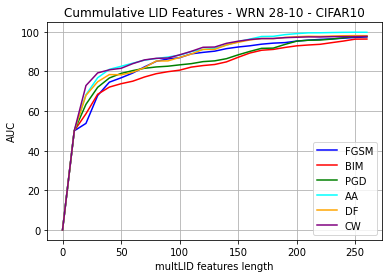

In [24]:
fig, ax = plt.subplots()
plt.title('Cummulative LID Features - WRN 28-10 - CIFAR10')
plt.ylabel("AUC")
plt.xlabel("multLID features length")
x = np.arange(0, length+stepsize, stepsize)
for it, att in enumerate(attacks):
    plt.plot(x, dict_res[att], label=labels[it], color=cdict[it])

plt.grid()
plt.legend()

In [25]:
ax.figure.savefig("plots/cummulative_lid_features/cummulative_lid_features_cifar10.png", dpi=600, bbox_inches='tight')

# ImageNet

In [11]:
dict_res, length = calc_auc(attacks, mode="imagenet")

attack fgsm
(2000, 510)
length 510 10
attack bim
(2000, 510)
length 510 10
attack pgd
(2000, 510)
length 510 10
attack aa
(2000, 510)
length 510 10
attack df
(2000, 510)
length 510 10
attack cw
(2000, 510)
length 510 10


In [12]:
len(dict_res["fgsm"])

52

In [13]:
len(x)

NameError: name 'x' is not defined

In [ ]:
attacks = ['fgsm', 'bim', 'pgd', 'aa', 'df', 'cw']
fig, ax = plt.subplots()
plt.title('Cummulative LID Features - WRN 50-2 - ImageNet')
plt.ylabel("AUC")
plt.xlabel("multiLID features length")
x = np.arange(0, length+stepsize, stepsize)
for it, att in enumerate(attacks):
    plt.plot(x, dict_res[att], label=labels[it], color=cdict[it])

plt.grid()
plt.legend()

In [ ]:
ax.figure.savefig("plots/cummulative_lid_features/cummulative_lid_features_imagenet.png", dpi=600, bbox_inches='tight')